# Risk Analysis for DonKa Detector

Initial tests to determine potential challenges for the DonKa Detector

## Assessments

 1. Options for audio streaming
 2. Optimizing for Digital Signal Processing (DSP)
    1. Might want to pivot away from Python. 
    2. First, see how intensive operations are involving NumPy
 3. High-accuracy detection options
    1. Create datasets of pencil taps and Tatacon usage
    2. Detection using statistics
       1. Quantile analysis of the DFT
       2. Mean/Median-based detectuib

### 1. Options for audio streaming

In [ ]:
import pyaudio
import wave
import math

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 512
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

In [ ]:
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

In [ ]:
import time

device_index = 2
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = device_index,
                frames_per_buffer=CHUNK)

Recordframes = []
 
for i in range(0, math.ceil(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    Recordframes.append(data)

In [ ]:
stream.stop_stream()
stream.close()
audio.terminate()

In [ ]:
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(Recordframes))
waveFile.close()

### 2. Options for DSP

Use the same setup as for assessment (1), but see how quickly we can perform operations using NumPy and librosa

https://librosa.org/doc/latest/generated/librosa.effects.percussive.html#librosa.effects.percussive

#### Assessment of NumPy

In [15]:
import pyaudio
import wave
import math

FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 16000
CHUNK = 4096
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Microphone (Realtek(R) Audio)


**Assessment**: We can play around with different rates and chunk sizes. On my hardware, NumPy is more than fast enough

In [16]:
import time
import numpy as np

device_index = 1
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = device_index,
                frames_per_buffer=CHUNK)

audio_arr = np.zeros((RATE, ))
np_time = 0
 
for i in range(0, math.ceil(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    start=time.time()
    # Shift Audio array
    audio_arr[:-CHUNK] = audio_arr[CHUNK:]
    audio_arr[-CHUNK:] = np.frombuffer(data, dtype=np.float32)
    np_time += time.time()-start

stream.stop_stream()
stream.close()
audio.terminate()

np_time/RECORD_SECONDS

0.00019979476928710938

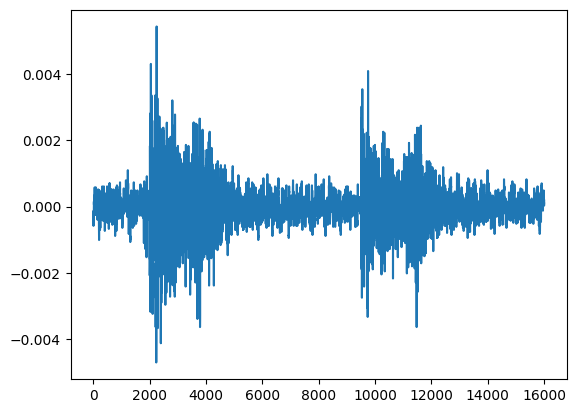

In [17]:
import matplotlib.pyplot as plt

plt.plot(audio_arr)

#### Assessment of Librosa

In [72]:
import pyaudio
import wave
import math

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 2048
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Microphone (Realtek(R) Audio)
Input Device id  2  -  Headset (2- WH-CH720N)


In [73]:
import time
import numpy as np
import librosa.onset

device_index = 2
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = device_index,
                frames_per_buffer=CHUNK)

audio_arr = np.zeros((RATE*RECORD_SECONDS + CHUNK, ))
onsets = np.array([audio_arr.shape[0]-1])
np_time,librosa_time = 0,0

def retrieve_onsets(audio_arr: np.ndarray) -> np.ndarray:
    this_onsets = librosa.onset.onset_detect(y=audio_arr, sr=RATE, units="samples")
    cleaned_onsets = []
    for onset in this_onsets:
        if np.max(np.abs(audio_arr[onset - RATE // 20:onset + RATE // 20])) >= 500 / (1 << 15):
            cleaned_onsets.append(int(onset))
    return np.array(cleaned_onsets)
 
for i in range(0, math.ceil(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    start=time.time()
    # Shift Audio array
    audio_arr[:-CHUNK] = audio_arr[CHUNK:]
    audio_arr[-CHUNK:] = np.frombuffer(data, dtype=np.int16) / (1 << 15)
    np_time += time.time()-start
    onsets -= CHUNK

    # Librosa onsets
    this_audio = audio_arr[int(onsets[-1]):]
    if len(this_audio) == 0 or np.max(np.abs(this_audio)) * (1 << 15) < 500: continue

    start = time.time()
    this_onsets = retrieve_onsets(this_audio)
    librosa_time += time.time() - start

    onsets = np.concatenate((onsets, this_onsets+onsets[-1] + RATE//20))


stream.stop_stream()
stream.close()
audio.terminate()

np_time/RECORD_SECONDS,librosa_time/RECORD_SECONDS

c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1921
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1633
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1345
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1569
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(


(0.0012026309967041015, 0.008327245712280273)

**Assessment**: Librosa is much more intensive, but the performance can vary widely depending on parameters, so must give users diverse performance options. Probably also presets. Also, use of Librosa should be limited in comparison to NumPy.

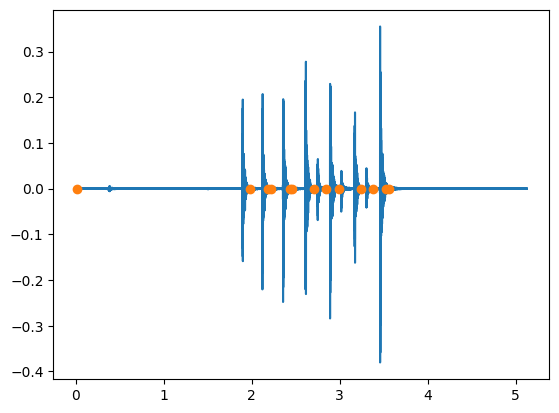

In [75]:
import librosa.onset
import matplotlib.pyplot as plt

plt.plot([i/RATE for i in range(audio_arr.shape[0])],audio_arr)
plt.plot(onsets/RATE, [0]*len(onsets), 'o')
#plt.plot(np.concatenate((onsets-RATE//20, onsets+RATE//20))/RATE, [0] * 2 * len(onsets), 'ro')
#plt.xlim(0.4, 2.25)
plt.show()

### Detection Options

#### Dataset Loading

In [1]:
import time
import numpy as np
import librosa

audio_arr, sr = librosa.load("../../datasets/pencil/data.mp3", sr=16000)

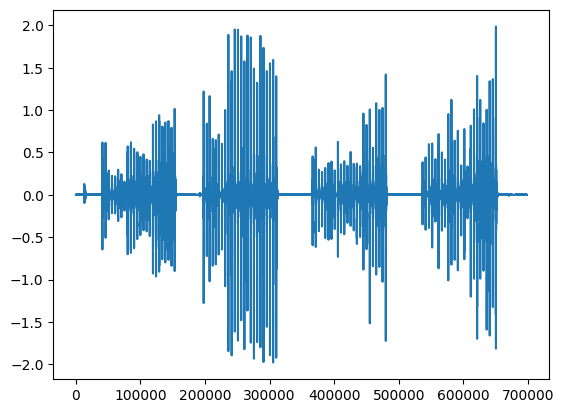

In [2]:
import matplotlib.pyplot as plt
import librosa.onset

plt.plot(np.array(range(len(audio_arr))), audio_arr)
plt.show()

0.0011877872


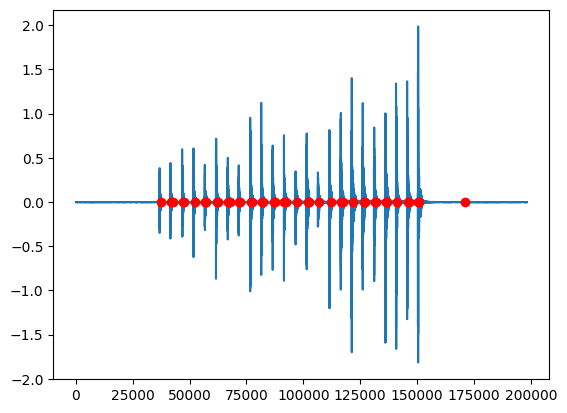

In [3]:
r_don = audio_arr[20000:175000]
l_don = audio_arr[175000:350000]
r_ka = audio_arr[350000:500000]
l_ka = audio_arr[500000:]

#r_don = audio_arr[:200000]
#l_don = audio_arr[200000:400000]
#r_ka = audio_arr[400000:600000]
#l_ka = audio_arr[600000:775000]

#r_don = audio_arr[:250000]
#l_don = audio_arr[250000:450000]
#r_ka = audio_arr[450000:625000]
#l_ka = audio_arr[625000:]

plt.plot(np.array(range(len(l_ka))), l_ka)
onsets = librosa.onset.onset_detect(y=l_ka, sr=sr, units="samples")
plt.plot(onsets, [0] * len(onsets), 'ro')
print(np.max(l_ka[-10000:]))
plt.show()

#### Data Preprocessing

Need to test how viable it is to retrieve the DonKa data from users

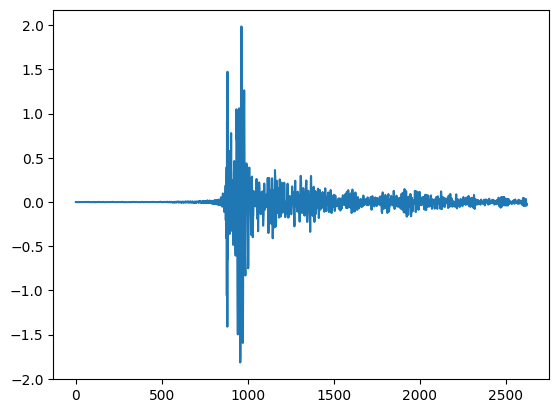

(24,
 [2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624,
  2624],
 [np.float32(0.38390386),
  np.float32(0.44180793),
  np.float32(0.5980993),
  np.float32(0.62209105),
  np.float32(0.42153248),
  np.float32(0.86763364),
  np.float32(0.50006014),
  np.float32(0.41524187),
  np.float32(1.01038),
  np.float32(1.1224),
  np.float32(0.7676672),
  np.float32(0.89054954),
  np.float32(0.48025572),
  np.float32(0.77630097),
  np.float32(0.33525243),
  np.float32(1.201891),
  np.float32(1.0085742),
  np.float32(1.6992258),
  np.float32(1.1200446),
  np.float32(0.8953911),
  np.float32(1.5918242),
  np.float32(1.6609194),
  np.float32(1.3654923),
  np.float32(1.9865861)])

In [4]:
from typing import List
def get_notes(array: np.ndarray, frame_left: int=1024, frame_right: int=3584) -> List[np.ndarray]:
    ret: List[np.ndarray] = []
    max_amp: List[int] = []
    
    onsets = librosa.onset.onset_detect(y=array, sr=sr, units="samples")
    last_onset = -frame_right
    for onset in onsets:
        if onset <= last_onset + frame_right:
            last_onset = onset
            continue
        wav = array[max(onset-frame_left, 0):min(onset+frame_right,len(array))]
        if wav.shape[0]==0:
            continue
        ret.append(wav)
        max_amp.append(np.max(np.abs(wav)))
        last_onset = onset
        
    amp_lowerbound: int = sorted(max_amp)[-24]
    return [wav for idx,wav in enumerate(ret) if max_amp[idx] >= amp_lowerbound - 1e-9]

result = get_notes(l_ka, frame_right=1600)
plt.plot(result[-1])
plt.show()
len(result),[i.shape[0] for i in result],[np.max(np.abs(i)) for i in result]

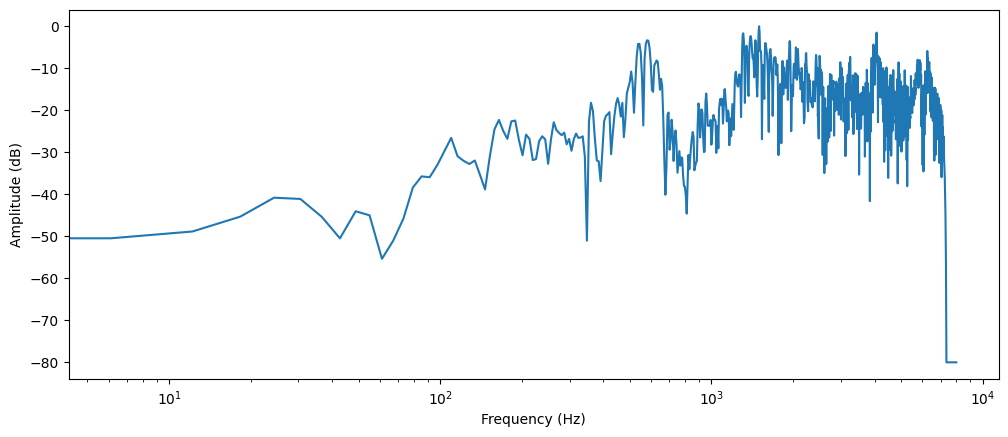

In [5]:
dft_input = result[0]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sr, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

In [6]:
r_don,l_don,r_ka,l_ka=[get_notes(i) for i in [r_don,l_don,r_ka,l_ka]]

#### Summary Statistics

Analyze if there are differences in DFT between each note, looking at the mean squared differences

In [8]:
def compute_mel_rep(note: np.ndarray, n_fft: int=1024) -> np.ndarray:
    window = np.hanning(len(note))
    windowed_input = notei * window
    dfti = np.fft.rfft(windowed_input)
    dfti = np.abs(dfti)
    dfti /= np.sum(dfti)

    #return np.abs(librosa.feature.melspectrogram(y=note, sr=sr, n_mels=128, fmax=8000, center=False, n_fft=n_fft))
    
    return np.abs(librosa.feature.melspectrogram(y=note, sr=sr, n_mels=128, fmax=8000, center=False, n_fft=n_fft))[:,2]
all_notes = r_don + l_don + r_ka + l_ka

diff = np.zeros((len(all_notes), len(all_notes)))

for i,notei in enumerate(all_notes):
    meli = compute_mel_rep(notei)
    for j,notej in enumerate(all_notes):
        melj = compute_mel_rep(notej)
        diff[i][j] = np.sum((meli - melj)**2)**0.5

In [9]:
len(all_notes)

96

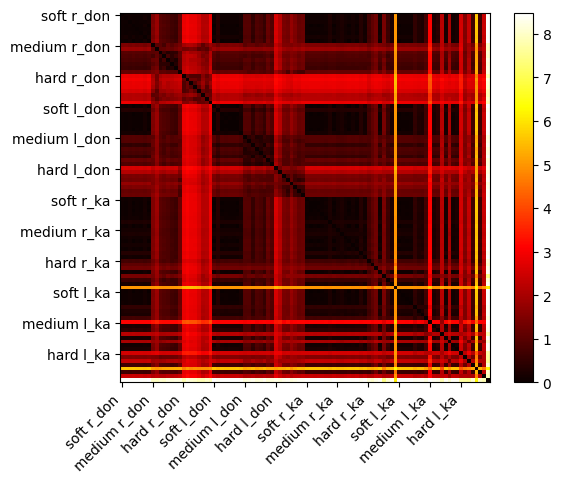

In [10]:
plt.imshow(diff, cmap="hot", interpolation="nearest")
plt.xticks(range(0,len(all_notes), 8), 
           ["soft r_don", "medium r_don", "hard r_don",
            "soft l_don", "medium l_don", "hard l_don",
            "soft r_ka", "medium r_ka", "hard r_ka",
            "soft l_ka", "medium l_ka", "hard l_ka",], 
           rotation=45, ha="right")
plt.yticks(range(0,len(all_notes), 8), 
           ["soft r_don", "medium r_don", "hard r_don",
            "soft l_don", "medium l_don", "hard l_don",
            "soft r_ka", "medium r_ka", "hard r_ka",
            "soft l_ka", "medium l_ka", "hard l_ka",])
plt.colorbar()
plt.show()

Darker color: Similar

Lighter color: Different

#### Detection

Create a 50/50 data split for all DonKa classes - soft/medium/hard RDon/LDon/RKa/LKa

Create note charts synthetically and determine how easily Dons and Kas can be identified. Make sure identification can happen quickly.


Something to keep in mind: Getting the side wrong is not devastating, but getting the note wrong is. I still want to differentiate between them.
Also, this formulation does not consider hitting on both sides, so this is playing under arcade rules

In [11]:
train_x = r_don[::2] + r_ka[::2] + l_don[::2] + l_ka[::2]
train_y = np.concatenate(
    (
        np.zeros((len(r_don[::2]),4)) + np.array([1,0,0,0]),
        np.zeros((len(r_ka[::2]),4))  + np.array([0,0,1,0]),
        np.zeros((len(l_don[::2]),4)) + np.array([0,1,0,0]),
        np.zeros((len(l_ka[::2]),4))  + np.array([0,0,0,1]),
    )
)
test_x = r_don[1::2] + r_ka[1::2] + l_don[1::2] + l_ka[1::2]
test_y = np.concatenate(
    (
        np.zeros((len(r_don[1::2]),4)) + np.array([1,0,0,0]),
        np.zeros((len(r_ka[1::2]),4))  + np.array([0,0,1,0]),
        np.zeros((len(l_don[1::2]),4)) + np.array([0,1,0,0]),
        np.zeros((len(l_ka[1::2]),4))  + np.array([0,0,0,1]),
    )
)

In [12]:
from typing import Tuple
import random

def create_random_chart(x: List[np.ndarray], y: np.ndarray, noise_std: float=0.01, note_rate: float=2, sr:int = sr, time_s: float = 5, frame_left: int=1024, frame_right: int=3584) -> Tuple[np.ndarray, np.ndarray]:
    # x: Arrays are wave forms
    # y: (len(x), 4): Class of each wave form in x
    # noise_std: Standard deviation of white noise added to signal
    # note_rate: notes per second
    # sr: sample rate
    # time_s: length of chart in seconds
    
    assert len(x) == len(y)
    assert y.shape==(len(x), 4)
    assert False not in [len(i.shape) == 1 for i in x]

    total_samples = int(sr*time_s)

    audio = np.random.normal(scale=noise_std,size=(total_samples,))
    chart = np.zeros((total_samples,4))

    samples_bw = int(sr / note_rate)

    # Get the waveforms for each class
    waveforms_class: List[List[np.ndarray]] = [[],[],[],[]]
    for donka,cls in zip(x,y):
        cls = np.argmax(cls)
        waveforms_class[cls].append(donka)

    # Add waveforms randomly, but on-beat. Use first second as background noise
    for i in range(sr, total_samples, samples_bw):
        note = np.random.randint(0,5)
        if note == 4:
            continue

        select_waveform = random.choice(waveforms_class[note])
        if i + frame_right >= total_samples:
            break
        chart[i][note] = 1
        audio[i-frame_left:i+frame_right] += select_waveform
    

    return audio,chart

audio,chart = create_random_chart(train_x, train_y, note_rate=8)

In [13]:
from IPython.display import Audio
Audio(audio, rate=sr)

Visualize spectrogram and chart

[1.0, 1.125, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.625, 2.75, 2.875, 3.125, 3.25, 3.375, 3.5, 3.625, 3.75, 3.875, 4.125, 4.25, 4.375, 4.5, 4.625, 4.75]
[0.096 1.024 1.056 1.184 1.376 1.408 1.536 1.664 1.76  1.888 2.016 2.144
 2.272 2.368 2.4   2.624 2.656 2.784 2.88  2.912 3.136 3.168 3.264 3.392
 3.424 3.616 3.648 3.776 3.872 3.904 4.128 4.16  4.256 4.416 4.544 4.672
 4.8  ]


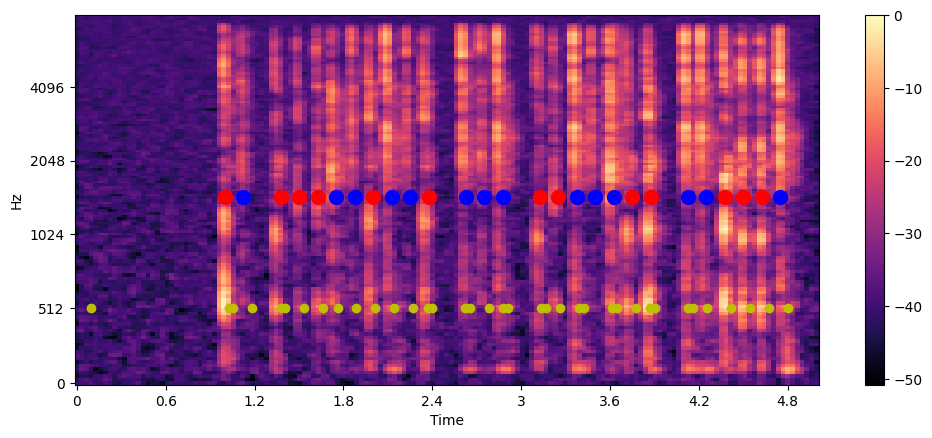

In [14]:
import librosa.feature

S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)

chart_sparse = [idx/sr for idx,i in enumerate(chart) if np.max(i) > 0.5]
chart_sparse_don = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) >= 2 and np.argmax(i) < 4]
chart_sparse_ka  = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) < 2]

plt.plot([idx/sr for i,idx in chart_sparse_don], [1024 * (2**.5)] * len(chart_sparse_don), "ro", markersize=10)
plt.plot([idx/sr for i,idx in chart_sparse_ka], [1024 * (2**.5)] * len(chart_sparse_ka), "bo", markersize=10)

onsets = librosa.onset.onset_detect(y=audio, sr=sr, units="time")

plt.plot(onsets, [512]*len(onsets), "yo")

print(chart_sparse)
print(onsets)
plt.colorbar()
plt.show()

Now that charts can be generated, let's see if we can accurately detect dons and kas using test notes!

##### KNN

Use the K most similar notes in the train set for prediction.

**Reasoning**: we actually have a lot of control over the data. If it's hard for the model to classify, we can just ask the user to try again. Additionally, we can ask the user to provide a variety of different Dons and Kas, like soft/medium/hard and left/right. So, we can assume that the data is ideal in some sense. The challenge is in training with a small dataset. The KNN can capture complex variations in real-time percussive audio inputs even with small training data: differences in volume, differences in pitch, and many more which I am not aware of. 

Define predictive model: Training process only involves giving the train notes and labels to the model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

def compute_mel_rep(note: np.ndarray) -> np.ndarray:

    return np.abs(librosa.feature.melspectrogram(y=note, sr=sr, n_mels=128, fmax=8000, center=False))[:,0]

def retrieve_chart(audio: np.ndarray, sr: int, train_x: List[np.ndarray], train_y: np.ndarray, frame_left: int=1024, frame_right: int=3584, K=5, normalize=True, feature=compute_mel_rep) -> List[Tuple[int, int]]:
    onsets = librosa.onset.onset_detect(y=audio, sr=sr, units="samples")

    random.seed(123)

    # Calculate RMS energy per frame.
    rms = librosa.feature.rms(y=audio, frame_length=512, hop_length=512)[0,]
    envtm = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=512)

    # Use first second as a representative of background noise
    noiseidx = envtm <= 1
    noisemedian = np.percentile(rms[noiseidx], 50)
    sigma = np.percentile(rms[noiseidx], 84.1) - noisemedian

    threshold = noisemedian + 5*sigma
    
    # Transform training data
    train_mel: List[np.ndarray] = [
        feature(note)
        for note in train_x
    ]
    if normalize: train_mel: List[np.ndarray] = [i/np.sum(i) for i in train_mel]

    answer = []

    knn = KNeighborsClassifier(K)
    knn.fit([i.flatten() for i in train_mel], [np.argmax(i) for i in train_y])
    last_note = -1e9

    # Classify each onset
    for onset in onsets:
        # Likely detecting the previous onset
        if onset < last_note + frame_left: continue

        note = audio[onset-1024:onset+1024]
        # Invalid position
        if note.shape != (1024 + 1024,):
            continue
        # Likely background noise
        if rms[onset//512] <= threshold:
            continue

        note_mel = feature(note)

        if normalize: note_mel /= np.sum(note_mel)

        # Problem-specific vote system
        votes = knn.predict_proba([note_mel.flatten()])[0]
        if votes[0] + votes[1] > votes[2] + votes[3]:
            answer.append((onset, np.argmax(votes[:2])))
        else:
            answer.append((onset, np.argmax(votes[2:4]) + 2))

        last_note = onset

        # Now spectral subtraction based on predicted mels
    return answer

pred = retrieve_chart(audio, sr, train_x, train_y)

Test how well this works on a single example

In [54]:
audio,chart = create_random_chart(test_x, test_y, note_rate=2, noise_std=0)

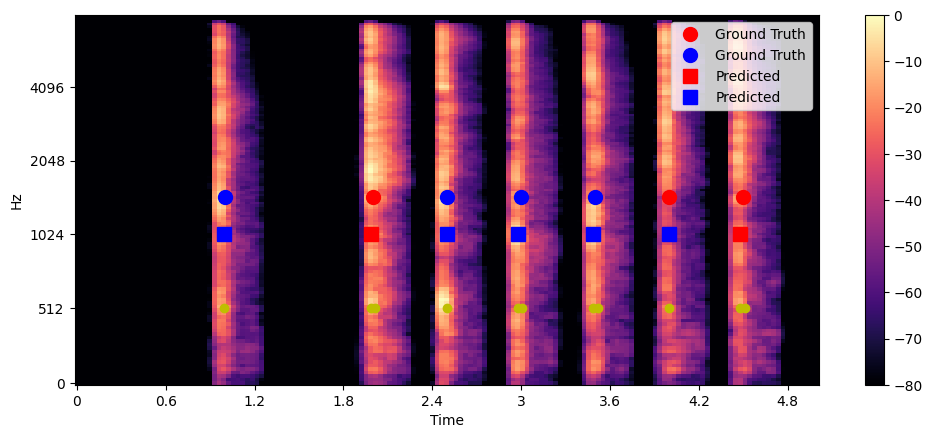

In [55]:
import librosa.feature

pred = retrieve_chart(audio, sr, train_x, train_y, K=2, normalize=False)

S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)

chart_sparse = [idx/sr for idx,i in enumerate(chart) if np.max(i) > 0.5]
chart_sparse_ka  = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) >= 2]
chart_sparse_don = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) < 2]
pred_don = [idx/sr for idx,i in pred if i < 2]
pred_ka = [idx/sr for idx,i in pred if i >= 2 and i < 4]

plt.plot([idx/sr for i,idx in chart_sparse_don], [1024 * (2**.5)] * len(chart_sparse_don), "ro", markersize=10, label="Ground Truth")
plt.plot([idx/sr for i,idx in chart_sparse_ka], [1024 * (2**.5)] * len(chart_sparse_ka), "bo", markersize=10, label="Ground Truth")
plt.plot([t for t in pred_don], [1024] * len(pred_don), "rs", markersize=10, label="Predicted")
plt.plot([t for t in pred_ka], [1024] * len(pred_ka), "bs", markersize=10, label="Predicted")

onsets = librosa.onset.onset_detect(y=audio, sr=sr, units="time")

plt.plot(onsets, [512]*len(onsets), "yo")

plt.legend()

plt.colorbar()
plt.show()

Evaluations based on Levenshtein edit distance.

I will assume that note positions are accurately determined: This is one of the limitations of the metric. But I don't expect positions are an issue based on my previous assessments. Additionally, for any delay, the user will provide an offset in-game.

This maps to every miss case: Missing from choosing the wrong note, missing from excluding/including a note

In [44]:
from tqdm import tqdm
from Levenshtein import distance as levenshtein_distance

experiments: List[Tuple[int,float]] = [ # Number of examples, note_rate
    (10, 1),
    (10, 1.5),
    (10, 2),
    (10, 2.5),
    (10, 3),
    (10, 4),
    (10, 5),
    (10, 6),
    (10, 7),
    (10, 8),
]

def evaluate(normalize: bool, K: int, experiments: List[Tuple[int,float]], verbose=True, seed: int=42, feature=compute_mel_rep):
    # So datasets are the same per-evaluation
    np.random.seed(seed)
    random.seed(seed)


    hist = []

    # Metrics over all experiments
    total_base_distance = 0
    total_bin_distance = 0
    total_pred = 0

    for samples,note_rate in experiments:
        # Experiment-specific metric
        num_pred = 0
        base_l_distance = 0
        bin_l_distance = 0

        pbar = range(samples)
        if verbose:
            pbar = tqdm(range(samples), desc=f"Experiment {samples}-{note_rate}")
        for i in pbar:
            # Create test data
            audio, chart_gt = create_random_chart(test_x, test_y, note_rate=note_rate, sr=sr, noise_std=0)
            chart_gt_sparse = [np.argmax(i) for idx,i in enumerate(chart_gt) if np.max(i) > 0.5]
            
            # Predict chart
            chart_pred = retrieve_chart(audio, sr, train_x, train_y, K=K, normalize=normalize, feature=feature)
            chart_pred = [cls for onset,cls in chart_pred]

            # Compute metrics
            base_l_distance += levenshtein_distance(chart_gt_sparse, chart_pred)

            chart_pred = [cls//2 for cls in chart_pred]
            chart_gt_sparse = [cls//2 for cls in chart_gt_sparse]
            bin_l_distance += levenshtein_distance(chart_gt_sparse, chart_pred)

            num_pred += len(chart_pred)
            if i==samples-1 and verbose:
                pbar.set_description(f"Experiment {samples}-{note_rate}, Base: ({base_l_distance},{num_pred}), Binary: ({bin_l_distance},{num_pred})")

        hist.append((base_l_distance, bin_l_distance, num_pred))

        total_base_distance += base_l_distance
        total_bin_distance += bin_l_distance
        total_pred += num_pred
    return (total_base_distance, total_bin_distance, total_pred),hist

Let's do a grid search for hyperparameters

In [45]:
hp = [
    [normalize, k]
    for k in range(1,6)
    for normalize in (True, False)
]

In [46]:
results = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results.append(evaluate(normalize, k, experiments=experiments))

Hyperparameters: normalize=True, K=1


Experiment 10-6, Base: (3,190), Binary: (3,190): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-7, Base: (14,210), Binary: (12,210): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
Experiment 10-8, Base: (40,215), Binary: (36,215): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-5, Base: (21,150), Binary: (5,150): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
Experiment 10-6, Base: (44,190), Binary: (25,190): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-7, Base: (72,210), Binary: (48,210): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
Experiment 10-8, Base: (89,215), Binary: (59,215): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-7, Base: (22,210), Binary: (9,210): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-8, Base: (46,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-5, Base: (18,150), Binary: (2,150): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
Experiment 10-6, Base: (37,190), Binary: (14,190): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]
Experiment 10-7, Base: (69,210), Binary: (30,210): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-8, Base: (94,215), Binary: (47,215): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-6, Base: (9,190), Binary: (6,190): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
Experiment 10-7, Base: (15,210), Binary: (11,210): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
Experiment 10-8, Base: (39,215), Binary: (36,215): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-4, Base: (10,130), Binary: (8,130): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-5, Base: (13,150), Binary: (10,150): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
Experiment 10-6, Base: (39,190), Binary: (28,190): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]
Experiment 10-7, Base: (66,210), Binary: (52,210): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]
Experiment 10-8, Base: (102,215), Binary: (68,215): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-6, Base: (10,190), Binary: (4,190): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]
Experiment 10-7, Base: (25,210), Binary: (10,210): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]
Experiment 10-8, Base: (46,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-5, Base: (24,150), Binary: (9,150): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-6, Base: (47,190), Binary: (26,190): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]
Experiment 10-7, Base: (73,210), Binary: (51,210): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]
Experiment 10-8, Base: (105,215), Binary: (66,215): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-5, Base: (2,150), Binary: (1,150): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]
Experiment 10-6, Base: (12,190), Binary: (11,190): 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]
Experiment 10-7, Base: (18,210), Binary: (12,210): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-8, Base: (48,215), Binary: (42,215): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-3, Base: (4,102), Binary: (4,102): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]
Experiment 10-4, Base: (10,130), Binary: (10,130): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-5, Base: (19,150), Binary: (10,150): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]
Experiment 10-6, Base: (44,190), Binary: (30,190): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
Experiment 10-7, Base: (74,210), Binary: (52,210): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]
Experiment 10-8, Base: (106,215), Binary: (71,215): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [47]:
non_normalized = [(k, bin_d/total, hist) for (normalize,k),((base_d,bin_d,total),hist) in zip(hp,results) if not normalize]
normalized = [(k, bin_d/total, hist) for (normalize,k),((base_d,bin_d,total),hist) in zip(hp,results) if normalize]

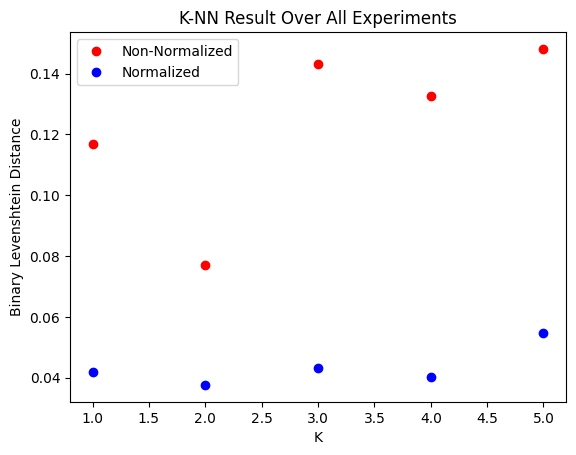

In [48]:
plt.plot([x[0] for x in non_normalized], [x[1] for x in non_normalized], 'ro', label="Non-Normalized")
plt.plot([x[0] for x in normalized], [x[1] for x in normalized], 'bo', label="Normalized")
plt.xlabel("K")
plt.ylabel("Binary Levenshtein Distance")
plt.title("K-NN Result Over All Experiments")
plt.legend()
plt.show()

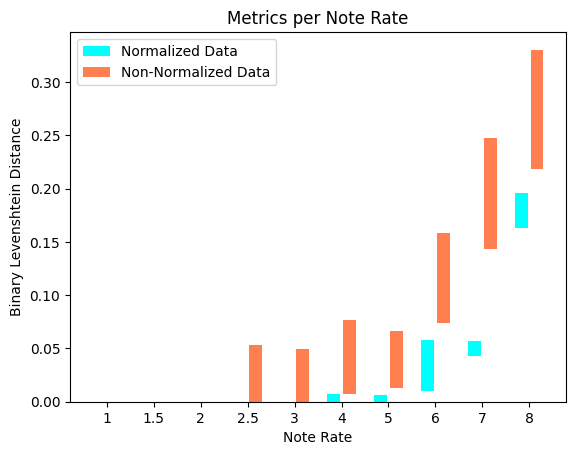

In [49]:
data = [[x[2][experiment][1]/x[2][experiment][2] for x in normalized] for experiment in range(len(experiments))]
plt.bar(np.array(range(len(experiments))) * 3, 
        np.ptp(data, axis=1), 
        bottom=np.min(data, axis=1), 
        color="aqua",
        label="Normalized Data")

data = [[x[2][experiment][1]/x[2][experiment][2] for x in non_normalized] for experiment in range(len(experiments))]
plt.bar(np.array(range(len(experiments))) * 3 + 1, 
        np.ptp(data, axis=1), 
        bottom=np.min(data, axis=1), 
        color="coral",
        label="Non-Normalized Data")

plt.legend()
plt.xticks(np.array(range(len(experiments))) * 3 + 0.5, [e[1] for e in experiments])
plt.xlabel("Note Rate")
plt.ylabel("Binary Levenshtein Distance")

plt.title("Metrics per Note Rate")
    
plt.show()

Note: If the bar does not appear, distances are 0

An interesting trend emerged across all datasets. For a note rate < 5, normalizing before computing similarity scores results in a better result, but for a note rate >= 5, it is better not to normalize. Another strange trend is that the performance of the non-normalized version becomes more stable as the note rate increases. This suggests some ensemble method may highly benefit predictions. Because of the nature of KNN, this is only about twice as computationally intensive (since we only have two distances to compute: the non-normalized and normalized version). If I use a model selection method, this may only be negligibly more intensive to compute.

There is some logic behind not normalizing: by normalizing, information about amplitude is lost.

But there is also a reason to normalize: it allows comparisons to be more general.

It is unclear why ideal model selection is dependent on note rate.

What I've also discovered is that the results seem to depend on the volume of the lightest sound. When testing on datasets with lighter sounds, the white noise is mistaken for an onset, resulting in several misses when the note rate is small. This inspires a more formal approach to tracking background noise.

Test on real data

In [251]:
import numpy as np
import librosa

audio_arr, sr = librosa.load("../../datasets/voice/kimi-no-akari.mp3", sr=16000)

pred = retrieve_chart(audio_arr, sr, train_x, train_y, normalize=True, K=5)

[]

[1.0, 1.5, 2.0, 2.5, 3.0, 4.5]
[0.096 0.608 0.64  0.992 1.024 1.216 1.248 1.472 1.504 1.856 1.888 2.336
 2.368 2.592 2.624 2.816 2.848 3.296 3.328 3.776 4.256 4.288 4.736 4.768
 4.96  4.992 5.216 5.248 5.696 5.728 6.208 6.24  6.72  6.752 6.944 6.976
 7.232 7.264 7.456 7.488 7.68  7.712]


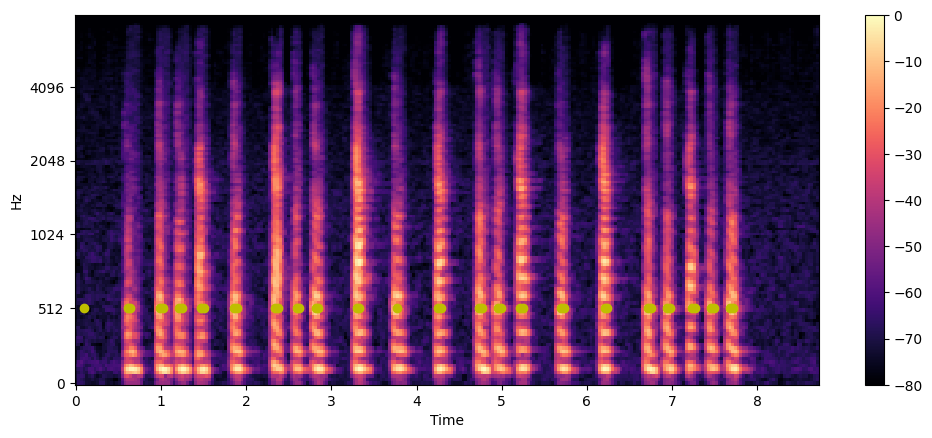

In [250]:
import librosa.feature

S = librosa.feature.melspectrogram(y=audio_arr, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)

pred_don = [idx/sr for idx,i in pred if i < 2]
pred_ka = [idx/sr for idx,i in pred if i >= 2 and i < 4]

plt.plot([t for t in pred_don], [1024] * len(pred_don), "rs", markersize=10, label="Predicted")
plt.plot([t for t in pred_ka], [1024] * len(pred_ka), "bs", markersize=10, label="Predicted")

onsets = librosa.onset.onset_detect(y=audio_arr, sr=sr, units="time")

plt.plot(onsets, [512]*len(onsets), "yo")

print(chart_sparse)
print(onsets)
plt.colorbar()
plt.show()

Again, issues come up when notes are quiet, which inspires a more formal approach to background noise tracking.

##### Feature Engineering

In [24]:
def compute_mel_rep(note: np.ndarray, idx: int) -> np.ndarray:

    return np.abs(librosa.feature.melspectrogram(y=note, sr=sr, n_mels=128, fmax=8000))[:,idx]

In [25]:
hp = [
    [normalize, k]
    for k in range(1,6)
    for normalize in (True, False)
]

In [27]:
results0 = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results0.append(evaluate(normalize, k, experiments=experiments, feature=lambda note: compute_mel_rep(note, 0)))

Hyperparameters: normalize=True, K=1


Experiment 10-7, Base: (17,210), Binary: (8,210): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]
Experiment 10-8, Base: (42,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-2.5, Base: (23,75), Binary: (6,75): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]
Experiment 10-3, Base: (30,102), Binary: (15,102): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
Experiment 10-6, Base: (43,190), Binary: (5,190): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
Experiment 10-7, Base: (47,210), Binary: (13,210): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
Experiment 10-8, Base: (72,215), Binary: (37,215): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-7, Base: (18,210), Binary: (8,210): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
Experiment 10-8, Base: (44,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-6, Base: (28,190), Binary: (5,190): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]
Experiment 10-7, Base: (43,210), Binary: (16,210): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]
Experiment 10-8, Base: (62,215), Binary: (37,215): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-7, Base: (17,210), Binary: (8,210): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]
Experiment 10-8, Base: (43,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-6, Base: (39,190), Binary: (4,190): 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]
Experiment 10-7, Base: (40,210), Binary: (14,210): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-8, Base: (71,215), Binary: (37,215): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-7, Base: (24,210), Binary: (8,210): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
Experiment 10-8, Base: (45,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-3, Base: (31,102), Binary: (6,102): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
Experiment 10-4, Base: (33,130), Binary: (10,130): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]
Experiment 10-7, Base: (36,210), Binary: (9,210): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
Experiment 10-8, Base: (69,215), Binary: (36,215): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-7, Base: (16,210), Binary: (8,210): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]
Experiment 10-8, Base: (40,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-1, Base: (14,30), Binary: (5,30): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
Experiment 10-1.5, Base: (22,51), Binary: (11,51): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]
Experiment 10-2.5, Base: (28,75), Binary: (6,75): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
Experiment 10-3, Base: (35,102), Binary: (12,102): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-6, Base: (44,190), Binary: (6,190): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
Experiment 10-7, Base: (57,210), Binary: (14,210): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-8, Base: (81,215), Binary: (40,215): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


In [28]:
results1 = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results1.append(evaluate(normalize, k, experiments=experiments, feature=lambda note: compute_mel_rep(note, 1)))

Hyperparameters: normalize=True, K=1


Experiment 10-7, Base: (9,210), Binary: (8,210): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]
Experiment 10-8, Base: (37,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-6, Base: (26,190), Binary: (9,190): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-7, Base: (28,210), Binary: (13,210): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]
Experiment 10-8, Base: (58,215), Binary: (39,215): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-7, Base: (13,210), Binary: (8,210): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
Experiment 10-8, Base: (41,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-6, Base: (8,190), Binary: (6,190): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-7, Base: (15,210), Binary: (10,210): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
Experiment 10-8, Base: (39,215), Binary: (36,215): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-7, Base: (8,210), Binary: (8,210): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
Experiment 10-8, Base: (35,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-5, Base: (4,150), Binary: (4,150): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-6, Base: (15,190), Binary: (14,190): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]
Experiment 10-7, Base: (16,210), Binary: (14,210): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
Experiment 10-8, Base: (47,215), Binary: (42,215): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-7, Base: (10,210), Binary: (8,210): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
Experiment 10-8, Base: (37,215), Binary: (35,215): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-6, Base: (12,190), Binary: (7,190): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
Experiment 10-7, Base: (19,210), Binary: (11,210): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
Experiment 10-8, Base: (43,215), Binary: (37,215): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-7, Base: (9,210), Binary: (9,210): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]
Experiment 10-8, Base: (35,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-5, Base: (8,150), Binary: (4,150): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]
Experiment 10-6, Base: (17,190), Binary: (16,190): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-7, Base: (19,210), Binary: (13,210): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]
Experiment 10-8, Base: (47,215), Binary: (42,215): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


In [29]:
results2 = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results2.append(evaluate(normalize, k, experiments=experiments, feature=lambda note: compute_mel_rep(note, 2)))

Hyperparameters: normalize=True, K=1


Experiment 10-6, Base: (3,190), Binary: (3,190): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-7, Base: (14,210), Binary: (12,210): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-8, Base: (40,215), Binary: (36,215): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-5, Base: (21,150), Binary: (5,150): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
Experiment 10-6, Base: (44,190), Binary: (25,190): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]
Experiment 10-7, Base: (72,210), Binary: (48,210): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
Experiment 10-8, Base: (89,215), Binary: (59,215): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-7, Base: (22,210), Binary: (9,210): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-8, Base: (46,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-5, Base: (18,150), Binary: (2,150): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-6, Base: (37,190), Binary: (14,190): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]
Experiment 10-7, Base: (69,210), Binary: (30,210): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-8, Base: (94,215), Binary: (47,215): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-6, Base: (9,190), Binary: (6,190): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-7, Base: (15,210), Binary: (11,210): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
Experiment 10-8, Base: (39,215), Binary: (36,215): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-4, Base: (10,130), Binary: (8,130): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
Experiment 10-5, Base: (13,150), Binary: (10,150): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]
Experiment 10-6, Base: (39,190), Binary: (28,190): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-7, Base: (66,210), Binary: (52,210): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
Experiment 10-8, Base: (102,215), Binary: (68,215): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-6, Base: (10,190), Binary: (4,190): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
Experiment 10-7, Base: (25,210), Binary: (10,210): 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]
Experiment 10-8, Base: (46,215), Binary: (35,215): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-5, Base: (24,150), Binary: (9,150): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-6, Base: (47,190), Binary: (26,190): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]
Experiment 10-7, Base: (73,210), Binary: (51,210): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]
Experiment 10-8, Base: (105,215), Binary: (66,215): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-5, Base: (2,150), Binary: (1,150): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
Experiment 10-6, Base: (12,190), Binary: (11,190): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]
Experiment 10-7, Base: (18,210), Binary: (12,210): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
Experiment 10-8, Base: (48,215), Binary: (42,215): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-3, Base: (4,102), Binary: (4,102): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
Experiment 10-4, Base: (10,130), Binary: (10,130): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-5, Base: (19,150), Binary: (10,150): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]
Experiment 10-6, Base: (44,190), Binary: (30,190): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]
Experiment 10-7, Base: (74,210), Binary: (52,210): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]
Experiment 10-8, Base: (106,215), Binary: (71,215): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


In [30]:
results3 = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results3.append(evaluate(normalize, k, experiments=experiments, feature=lambda note: compute_mel_rep(note, 3)))

Hyperparameters: normalize=True, K=1


Experiment 10-6, Base: (11,190), Binary: (8,190): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
Experiment 10-7, Base: (33,210), Binary: (27,210): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]
Experiment 10-8, Base: (78,215), Binary: (55,215): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-4, Base: (29,130), Binary: (9,130): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
Experiment 10-5, Base: (41,150), Binary: (13,150): 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
Experiment 10-6, Base: (67,190), Binary: (33,190): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
Experiment 10-7, Base: (86,210), Binary: (47,210): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]
Experiment 10-8, Base: (105,215), Binary: (68,215): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-6, Base: (18,190), Binary: (7,190): 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
Experiment 10-7, Base: (41,210), Binary: (22,210): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
Experiment 10-8, Base: (85,215), Binary: (54,215): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-4, Base: (31,130), Binary: (4,130): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
Experiment 10-5, Base: (51,150), Binary: (15,150): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
Experiment 10-6, Base: (79,190), Binary: (28,190): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]
Experiment 10-7, Base: (86,210), Binary: (28,210): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
Experiment 10-8, Base: (106,215), Binary: (58,215): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-6, Base: (17,190), Binary: (9,190): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
Experiment 10-7, Base: (46,210), Binary: (25,210): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
Experiment 10-8, Base: (87,215), Binary: (59,215): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-2.5, Base: (17,75), Binary: (9,75): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
Experiment 10-3, Base: (25,102), Binary: (14,102): 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]
Experiment 10-4, Base: (34,130), Binary: (18,130): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
Experiment 10-5, Base: (48,150), Binary: (21,150): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
Experiment 10-6, Base: (79,190), Binary: (52,190): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
Experiment 10-7, Base: (105,210), Binary: (75,210): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]
Experiment 10-8, Base: (115,215), Binary: (80,215): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-6, Base: (18,190), Binary: (7,190): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
Experiment 10-7, Base: (50,210), Binary: (25,210): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
Experiment 10-8, Base: (91,215), Binary: (58,215): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-2.5, Base: (20,75), Binary: (9,75): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]
Experiment 10-3, Base: (29,102), Binary: (14,102): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]
Experiment 10-4, Base: (37,130), Binary: (15,130): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]
Experiment 10-5, Base: (51,150), Binary: (21,150): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
Experiment 10-6, Base: (86,190), Binary: (53,190): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
Experiment 10-7, Base: (105,210), Binary: (74,210): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
Experiment 10-8, Base: (124,215), Binary: (78,215): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-5, Base: (5,150), Binary: (1,150): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
Experiment 10-6, Base: (16,190), Binary: (13,190): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
Experiment 10-7, Base: (50,210), Binary: (35,210): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-8, Base: (91,215), Binary: (62,215): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-2, Base: (25,69), Binary: (7,69): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
Experiment 10-2.5, Base: (24,75), Binary: (16,75): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]
Experiment 10-3, Base: (32,102), Binary: (16,102): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]
Experiment 10-4, Base: (42,130), Binary: (18,130): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
Experiment 10-5, Base: (50,150), Binary: (23,150): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
Experiment 10-6, Base: (93,190), Binary: (59,190): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]
Experiment 10-7, Base: (110,210), Binary: (82,210): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]
Experiment 10-8, Base: (124,215), Binary: (84,215): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


In [31]:
results4 = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results4.append(evaluate(normalize, k, experiments=experiments, feature=lambda note: compute_mel_rep(note, 4)))

Hyperparameters: normalize=True, K=1


Experiment 10-5, Base: (2,150), Binary: (2,150): 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]
Experiment 10-6, Base: (20,190), Binary: (13,190): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-7, Base: (69,210), Binary: (35,210): 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]
Experiment 10-8, Base: (92,215), Binary: (52,215): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-3, Base: (13,102), Binary: (1,102): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-4, Base: (32,130), Binary: (16,130): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
Experiment 10-5, Base: (42,150), Binary: (14,150): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]
Experiment 10-6, Base: (64,190), Binary: (31,190): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-7, Base: (81,210), Binary: (39,210): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-8, Base: (120,215), Binary: (56,215): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-5, Base: (2,150), Binary: (1,150): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
Experiment 10-6, Base: (18,190), Binary: (11,190): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]
Experiment 10-7, Base: (73,210), Binary: (33,210): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-8, Base: (90,215), Binary: (52,215): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-3, Base: (16,102), Binary: (2,102): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
Experiment 10-4, Base: (36,130), Binary: (13,130): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]
Experiment 10-5, Base: (48,150), Binary: (12,150): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]
Experiment 10-6, Base: (68,190), Binary: (26,190): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]
Experiment 10-7, Base: (89,210), Binary: (40,210): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]
Experiment 10-8, Base: (125,215), Binary: (60,215): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-5, Base: (5,150), Binary: (4,150): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
Experiment 10-6, Base: (26,190), Binary: (20,190): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
Experiment 10-7, Base: (68,210), Binary: (35,210): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
Experiment 10-8, Base: (86,215), Binary: (52,215): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-3, Base: (22,102), Binary: (9,102): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]
Experiment 10-4, Base: (42,130), Binary: (12,130): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
Experiment 10-5, Base: (57,150), Binary: (19,150): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]
Experiment 10-6, Base: (84,190), Binary: (45,190): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
Experiment 10-7, Base: (87,210), Binary: (40,210): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
Experiment 10-8, Base: (126,215), Binary: (64,215): 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-5, Base: (3,150), Binary: (3,150): 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
Experiment 10-6, Base: (26,190), Binary: (19,190): 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
Experiment 10-7, Base: (65,210), Binary: (35,210): 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
Experiment 10-8, Base: (92,215), Binary: (52,215): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-3, Base: (20,102), Binary: (2,102): 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
Experiment 10-4, Base: (38,130), Binary: (13,130): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]
Experiment 10-5, Base: (50,150), Binary: (24,150): 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
Experiment 10-6, Base: (67,190), Binary: (30,190): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Experiment 10-7, Base: (82,210), Binary: (38,210): 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
Experiment 10-8, Base: (125,215), Binary: (56,215): 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-5, Base: (8,150), Binary: (3,150): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
Experiment 10-6, Base: (31,190), Binary: (21,190): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]
Experiment 10-7, Base: (68,210), Binary: (36,210): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
Experiment 10-8, Base: (96,215), Binary: (52,215): 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-2.5, Base: (23,75), Binary: (7,75): 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]
Experiment 10-3, Base: (29,102), Binary: (12,102): 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]
Experiment 10-4, Base: (47,130), Binary: (19,130): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
Experiment 10-5, Base: (59,150), Binary: (31,150): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
Experiment 10-6, Base: (85,190), Binary: (48,190): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
Experiment 10-7, Base: (87,210), Binary: (46,210): 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Experiment 10-8, Base: (121,215), Binary: (69,215): 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


In [32]:
results5 = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results5.append(evaluate(normalize, k, experiments=experiments, feature=lambda note: compute_mel_rep(note, 5)))

Hyperparameters: normalize=True, K=1


Experiment 10-4, Base: (1,130), Binary: (0,130): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
Experiment 10-5, Base: (15,150), Binary: (10,150): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
Experiment 10-6, Base: (89,190), Binary: (42,190): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]
Experiment 10-7, Base: (92,210), Binary: (40,210): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]
Experiment 10-8, Base: (114,215), Binary: (54,215): 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-5, Base: (36,150), Binary: (9,150): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Experiment 10-6, Base: (97,190), Binary: (53,190): 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
Experiment 10-7, Base: (104,210), Binary: (70,210): 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
Experiment 10-8, Base: (133,215), Binary: (78,215): 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-4, Base: (4,130), Binary: (0,130): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]
Experiment 10-5, Base: (28,150), Binary: (10,150): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Experiment 10-6, Base: (88,190), Binary: (40,190): 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
Experiment 10-7, Base: (78,210), Binary: (33,210): 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]
Experiment 10-8, Base: (101,215), Binary: (50,215): 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-3, Base: (7,102), Binary: (2,102): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
Experiment 10-4, Base: (27,130), Binary: (10,130): 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
Experiment 10-5, Base: (46,150), Binary: (20,150): 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
Experiment 10-6, Base: (93,190), Binary: (48,190): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Experiment 10-7, Base: (106,210), Binary: (61,210): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Experiment 10-8, Base: (134,215), Binary: (71,215): 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-5, Base: (22,150), Binary: (8,150): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
Experiment 10-6, Base: (86,190), Binary: (40,190): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
Experiment 10-7, Base: (81,210), Binary: (32,210): 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
Experiment 10-8, Base: (102,215), Binary: (50,215): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-4, Base: (23,130), Binary: (6,130): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
Experiment 10-5, Base: (39,150), Binary: (21,150): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
Experiment 10-6, Base: (89,190), Binary: (47,190): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Experiment 10-7, Base: (114,210), Binary: (74,210): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]
Experiment 10-8, Base: (139,215), Binary: (81,215): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-5, Base: (20,150), Binary: (7,150): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
Experiment 10-6, Base: (87,190), Binary: (39,190): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
Experiment 10-7, Base: (78,210), Binary: (31,210): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Experiment 10-8, Base: (100,215), Binary: (50,215): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-2.5, Base: (16,75), Binary: (9,75): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]
Experiment 10-3, Base: (19,102), Binary: (12,102): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]
Experiment 10-4, Base: (30,130), Binary: (12,130): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
Experiment 10-5, Base: (50,150), Binary: (28,150): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]
Experiment 10-6, Base: (90,190), Binary: (47,190): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
Experiment 10-7, Base: (122,210), Binary: (69,210): 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Experiment 10-8, Base: (146,215), Binary: (80,215): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-5, Base: (10,150), Binary: (5,150): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
Experiment 10-6, Base: (86,190), Binary: (40,190): 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
Experiment 10-7, Base: (81,210), Binary: (31,210): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Experiment 10-8, Base: (102,215), Binary: (50,215): 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-2.5, Base: (11,75), Binary: (2,75): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
Experiment 10-3, Base: (19,102), Binary: (12,102): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
Experiment 10-4, Base: (25,130), Binary: (8,130): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Experiment 10-5, Base: (43,150), Binary: (18,150): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
Experiment 10-6, Base: (86,190), Binary: (49,190): 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
Experiment 10-7, Base: (117,210), Binary: (74,210): 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
Experiment 10-8, Base: (145,215), Binary: (88,215): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
